In [ ]:
!pip -q install --upgrade captum lime

### Зависимости

In [ ]:
import os, random, numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [ ]:
from captum.attr import (
    Saliency, IntegratedGradients, NoiseTunnel, Occlusion,
    LayerGradCam, GuidedBackprop, LayerAttribution
)

In [ ]:
from lime import lime_image
from skimage.segmentation import slic

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print("Device:", device)

Device: cuda


### Загрузка предобученной модели и утилит предобработки

In [ ]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).eval().to(device)
preprocess = weights.transforms()  # включает resize/crop/ToTensor/Normalize
class_names = weights.meta["categories"]

# Для отображения: просто приводим к 224x224 без нормализации
display_transform = transforms.Compose([
    transforms.Resize((224, 224))
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
def load_image_from_url(url: str) -> Image.Image:
    img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
    return img

def prepare_input(pil_img: Image.Image) -> torch.Tensor:
    return preprocess(pil_img).unsqueeze(0).to(device)

def predict_proba(input_tensor: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
    return probs

def topk_predictions(probs: torch.Tensor, k=5):
    topk = torch.topk(probs, k)
    idx = topk.indices[0].tolist()
    vals = topk.values[0].tolist()
    return [(class_names[i], float(v)) for i,v in zip(idx, vals)]

def show_image(pil_img, title=None):
    plt.figure(figsize=(3,3))
    plt.imshow(pil_img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

### Загрузка примеров изображений

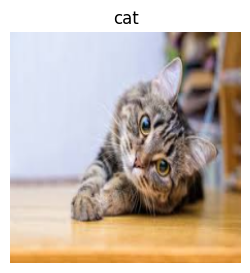

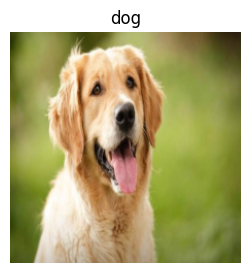

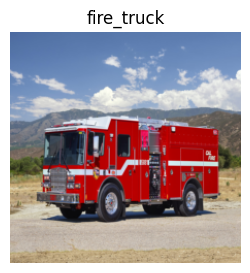

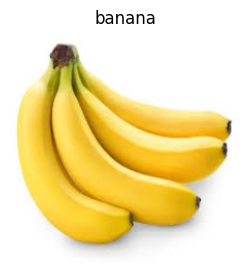

In [ ]:

urls = {
    "cat": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTxTGI0vO83mYNefqgTxdktvrBt-fRabdydNw&s",
    "dog": "https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/10-intelligent-dog-breeds/golden-retriever-tongue-out.jpg?h=430&w=710&hash=7FEB820D235A44B76B271060E03572C7",
    "fire_truck": "https://firetrucks.com/wp-content/uploads/2024/09/Hero-CALFIRE_24006-22449D2C-Low-Res-scaled.jpg",
    "banana": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6pnpSXDQ3gnqlEO6jLHlYyXzqNwHfgZ6VMQ&s",
}

images = {k: load_image_from_url(v) for k,v in urls.items()}
for name, img in images.items():
    show_image(display_transform(img), title=name)

### Базовые предсказания

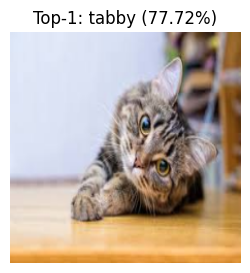

Top-5: [('tabby', 0.7771505117416382), ('Egyptian cat', 0.09963001310825348), ('tiger cat', 0.07213868200778961), ('lynx', 0.0254334956407547), ('wood rabbit', 0.006850915495306253)]


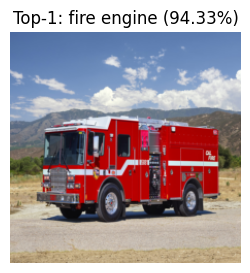

Top-5: [('fire engine', 0.9433290958404541), ('tow truck', 0.020809317007660866), ('trailer truck', 0.015656623989343643), ('ambulance', 0.004593754652887583), ('recreational vehicle', 0.0028576829936355352)]


In [ ]:
def predict_and_show(pil_img, k=5):
    x = prepare_input(pil_img)
    probs = predict_proba(x)
    preds = topk_predictions(probs, k=k)
    show_image(display_transform(pil_img), title="Top-1: {} ({:.2f}%)".format(
        preds[0][0], preds[0][1]*100))
    print("Top-5:", preds)

_ = predict_and_show(images["cat"])
_ = predict_and_show(images["fire_truck"])

### Вспомогательные функции визуализации атрибуций

In [ ]:
import cv2

def to_numpy(t):
    return t.detach().cpu().numpy()

def normalize_attr(attr: np.ndarray, eps=1e-8):
    # min-max по карте
    a = attr - attr.min()
    a = a / (a.max() + eps)
    return a

def overlay_attr_on_image(pil_img, attr_2d, alpha=0.5, cmap='jet'):
    img_disp = np.array(display_transform(pil_img))
    heatmap = cv2.applyColorMap((attr_2d*255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = (alpha*heatmap + (1-alpha)*img_disp).astype(np.uint8)
    plt.figure(figsize=(4,4))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

def aggregate_channels(attr_tensor):
    # суммируем по каналам и берем абсолютное значение
    attr = attr_tensor.abs().sum(dim=1, keepdim=True)
    return attr

### Saliency & SmoothGrad

**Saliency** (метод карты важности/градиентная карта) - это объясняющий подход, показывающий, какие части входного изображения (или другого типа данных) наиболее сильно влияют на конкретное предсказание модели.

- Отвечает на вопрос "какие пиксели (или регионы изображения) ответственны за текущий вывод класса?"

- Для входа X и целевого класса y, вычисляется градиент функции потерь/логита по каждому пикселю

Интуиция - если градиент пикселя положительный и большой по абсолютной величине, это означает, что увеличение значения пикселя увеличит оценку класса. Наоборот, отрицательный градиент указывает на то, что пиксель действует против предсказания.


**SmoothGrad** - это расширение стандартного Saliency-метода, решающее его главный недостаток: «шумность» или нестабильность карт важных пикселей.

Основная проблема обычного Saliency - карты часто оказываются слишком точечными, шумными, плохо интерпретируемыми. Малейшие изменения/шумы во входе сильно меняют карту важности.

Как работает SmoothGrad:
- К исходному изображению многократно добавляют небольшой случайный шум (например, гауссовый).
- Для каждого зашумлённого изображения рассчитывают Saliency карту (градиенты).
- Итоговая карта — это среднее из всех Saliency-карт по этим зашумлённым образцам.

Vanilla Saliency


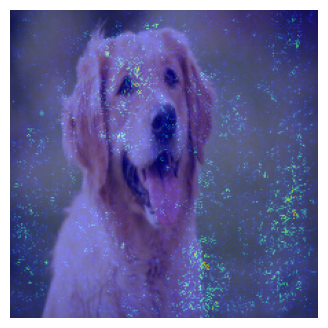

SmoothGrad


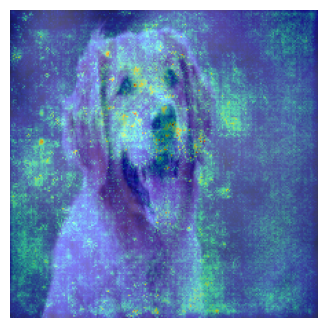

In [ ]:
def saliency_maps(pil_img, target=None, smooth=False):
    x = prepare_input(pil_img)
    x.requires_grad_()
    sal = Saliency(model)
    if smooth:
        nt = NoiseTunnel(sal)
        attr = nt.attribute(x, nt_type='smoothgrad', nt_samples=25, stdevs=0.1, target=target)
    else:
        attr = sal.attribute(x, target=target)
    attr = aggregate_channels(attr)  # [1,1,H,W]
    attr = to_numpy(attr)[0,0]
    attr = normalize_attr(attr)
    return attr

img = images["dog"]
# target = индекс предсказанного класса:
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()

attr_sal = saliency_maps(img, target=pred_idx, smooth=False)
attr_sg  = saliency_maps(img, target=pred_idx, smooth=True)

print("Vanilla Saliency")
overlay_attr_on_image(img, attr_sal)
print("SmoothGrad")
overlay_attr_on_image(img, attr_sg)

### Integrated Gradients

**Integrated Gradients** - это метод, который показывает, какой вклад каждый входной признак (пиксель, токен) вносит в предсказание модели, учитывая всю траекторию изменения от базового состояния до реального входа.

Как работает метод:
- Выбирается baseline — неинформативный вход (например, черное изображение, заполненное нулями, или padding для текста).
- Медленно «двигаемся» от baseline к настоящему входу, беря множество промежуточных шагов (интерполяция).
- Для каждого шага считаем градиенты выхода модели по входу (как в Saliency).
- Итоговая важность каждого признака — интеграл градиентов по траектории, то есть усреднение вклада на всём пути:

Integrated Gradients


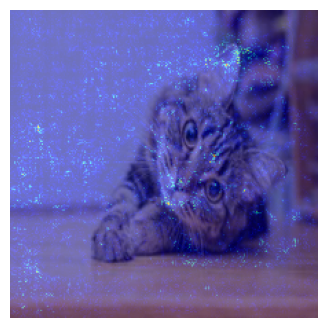

In [ ]:
def integrated_gradients(pil_img, target=None, baseline="black", steps=50):
    x = prepare_input(pil_img)
    ig = IntegratedGradients(model)
    if baseline == "black":
        baselines = torch.zeros_like(x)
    elif baseline == "random":
        baselines = torch.rand_like(x) * 0.5  # слабая засветка
    else:
        baselines = torch.zeros_like(x)
    attr = ig.attribute(x, baselines=baselines, target=target, n_steps=steps)
    attr = aggregate_channels(attr)
    attr = to_numpy(attr)[0,0]
    return normalize_attr(attr)

img = images["cat"]
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()
attr_ig = integrated_gradients(img, target=pred_idx, baseline="black", steps=80)

print("Integrated Gradients")
overlay_attr_on_image(img, attr_ig)

### Grad-CAM (LayerGradCam) и Guided Backprop

**Grad-CAM** (Gradient-weighted Class Activation Mapping) — это популярный метод визуализации внимания сверточных нейросетей (CNN), показывающий, какие регионы изображения наиболее важны для предсказания конкретного класса.

Как работает Grad-CAM:
- Выбирают целевой слой (обычно последний сверточный слой модели).
- Гоняют прямой проход (forward) — получают стандартный результат, класс и вероятности.
- Считают градиенты выхода для выбранного класса по активациям целевого слоя
- Считают «веса» каналов
- Комбинируют активации с весами
- Интерполируют карту до исходного размера изображения.
- Визуализируют как тепловую карту наложенную на исходное изображение.

Grad-CAM работает поверх слоев, захватывает более высокоуровневые пространственные паттерны (области).

Хорошо подходит для объяснения «на что смотрит» модель при классификации, детекции, сегментации.

**Guided Backpropagation** — это метод визуализации, который модифицирует стандартное обратное распространение, добавляя ReLU-masking для получения более чистых и детальных карт.

Ключевая идея — на ReLU слое Guided Backprop блокирует не только отрицательные активации входов, но и отрицательные градиенты

Grad-CAM


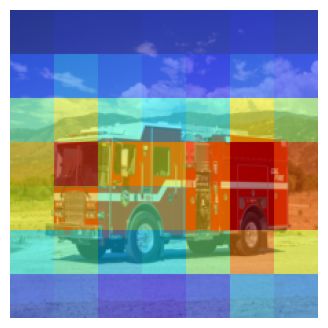

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:63: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/usr/local/lib/python3.12/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Guided Backprop (градиент на уровне пикселей)


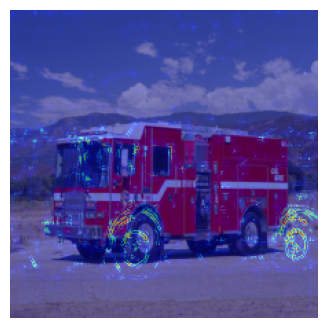

Guided Grad-CAM


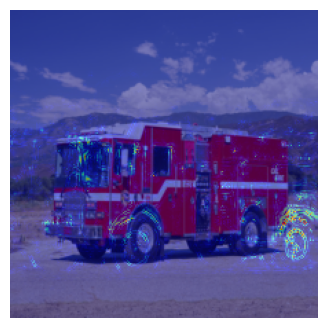

In [ ]:
# Целевой слой: последняя свертка в последнем блоке
target_layer = model.layer4[1].conv2

def grad_cam(pil_img, target=None):
    x = prepare_input(pil_img)
    lgc = LayerGradCam(model, target_layer)
    attr = lgc.attribute(x, target=target)
    # Интерполируем на размер входа
    attr_upsampled = LayerAttribution.interpolate(attr, x.shape[2:])
    # Суммируем по каналам (GradCam слойной уже 1x1xHxW; для надежности агрегируем)
    attr_agg = attr_upsampled.mean(dim=1, keepdim=True)
    attr_np = to_numpy(attr_agg)[0,0]
    return normalize_attr(attr_np)

def guided_backprop(pil_img, target=None):
    x = prepare_input(pil_img)
    gbp = GuidedBackprop(model)
    attr = gbp.attribute(x, target=target)
    attr = aggregate_channels(attr)
    attr = to_numpy(attr)[0,0]
    return normalize_attr(attr)

img = images["fire_truck"]
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()

attr_gc = grad_cam(img, target=pred_idx)
print("Grad-CAM")
overlay_attr_on_image(img, attr_gc)

attr_gbp = guided_backprop(img, target=pred_idx)
print("Guided Backprop (градиент на уровне пикселей)")
overlay_attr_on_image(img, attr_gbp)

# Guided Grad-CAM = элементное произведение GuidedBackprop и Grad-CAM (броадкаст)
ggcam = normalize_attr(attr_gbp * attr_gc)
print("Guided Grad-CAM")
overlay_attr_on_image(img, ggcam)

### Occlusion

**Occlusion** — это интуитивный и модель-независимый метод визуализации важности признаков, который объясняет, какие регионы входных данных (обычно изображения) критичны для предсказания модели.

Как работает Occlusion:
- Берётся окно фиксированного размера (например, 15×15 или 45×45 пикселей).

- Последовательно "закрашивают" (маскируют) этим окном разные регионы изображения (или блоки на входе), заменяя их, например, на черный или средний по интенсивности цвет.

- Каждый раз пропускают получившееся изображение через модель и смотрят, насколько сильно изменилось предсказание интересующего класса.

- Строят карту важности: в каждом регионе фиксируют «урон» — насколько сильно изменилась уверенность модели по отношению к целевому классу при замаскированном регионе.

- Если замаскировали важную часть — уверенность упала резко - высокая важность.

- Если замаскировали неважную часть — уверенность почти не изменилась - низкая важность.

Occlusion


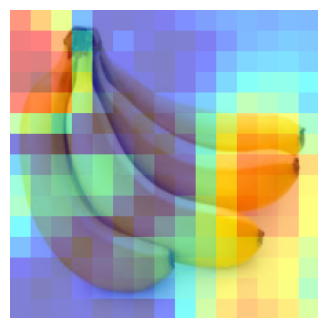

In [ ]:
def occlusion_attr(pil_img, target=None, window=45, stride=15):
    x = prepare_input(pil_img)
    occl = Occlusion(model)
    attr = occl.attribute(
        x, target=target,
        sliding_window_shapes=(3, window, window),
        strides=(3, stride, stride),
        baselines=0
    )
    attr = aggregate_channels(attr)
    attr = to_numpy(attr)[0,0]
    return normalize_attr(attr)

img = images["banana"]
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()
attr_occ = occlusion_attr(img, target=pred_idx, window=45, stride=15)

print("Occlusion")
overlay_attr_on_image(img, attr_occ)

### LIME

**LIME** (Local Interpretable Model-agnostic Explanations) — это универсальный метод для объяснения решения любой модели (не только нейросетей), который работает по принципу локального аппроксимирования важности признаков.

Как работает LIME:
- Выбирается конкретный пример (например, изображение или текст) и исходный класс-предсказание.

- Генерируются множество похожих вариантов этого примера (вариации, где части входа случайно «замаскированы» или изменены: для картинок — суперпиксели, для текста — слова).

- Вычисляются предсказания модели для каждого изменённого варианта.

- Строится простая интерпретируемая модель (обычно линейная регрессия или деревья), которая аппроксимирует поведение сложной модели строго в окрестности исходного примера.

- LIME определяет, какие фрагменты (суперпиксели, слова) максимально влияют на решение «здесь и сейчас».

- На выходе — веса, показывающие значимость каждого фрагмента (пикселя, слова) для оригинального предсказания.

  0%|          | 0/600 [00:00<?, ?it/s]

LIME (положительные суперпиксели)


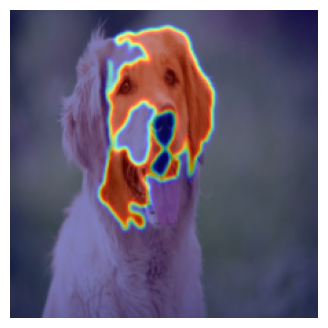

In [ ]:
def classifier_fn_for_lime(imgs_np_list):
    # imgs_np_list: список HxWx3 (0-255), RGB
    batch = []
    for arr in imgs_np_list:
        pil = Image.fromarray(arr.astype(np.uint8))
        batch.append(preprocess(pil))
    x = torch.stack(batch, dim=0).to(device)
    probs = predict_proba(x).detach().cpu().numpy()
    return probs

def lime_explain(pil_img, target_idx=None, n_segments=50, num_samples=800):
    img_disp = np.array(display_transform(pil_img))
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=img_disp,
        classifier_fn=classifier_fn_for_lime,
        top_labels=5,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=lambda x: slic(x, n_segments=n_segments, compactness=10, sigma=1)
    )
    if target_idx is None:
        # берем предсказанный класс в пространстве ImageNet
        target_idx = predict_proba(prepare_input(pil_img)).argmax(dim=1).item()

    temp, mask = explanation.get_image_and_mask(
        label=target_idx,
        positive_only=True,
        num_features=8,
        hide_rest=False
    )
    # Маску нормализуем
    mask = (mask > 0).astype(np.float32)
    mask = cv2.GaussianBlur(mask, (11,11), 0)
    mask = normalize_attr(mask)
    return mask

img = images["dog"]
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()
attr_lime = lime_explain(img, target_idx=pred_idx, n_segments=60, num_samples=600)

print("LIME (положительные суперпиксели)")
overlay_attr_on_image(img, attr_lime)

### Падение уверенности при маскировании важных пикселей

Падение уверенности при маскировании важных пикселей - это практическая проверка интерпретации модели, показывающая, насколько сильно ключевые (важные) области входа реально влияют на результат.

Как работает этот подход:
- Сначала вычисляется карта важности (например, Saliency, Integrated Gradients) для входного изображения и выбранного класса.

- Находятся самые важные пиксели — обычно берется топ-N% по важности (например, 20% с максимальными значениями атрибуции).

- Далее важные пиксели замаскировываются — их интенсивность заменяется на ноль, средний цвет, или шум.

- Пропускают модифицированное изображение через модель снова и вычисляют новую «уверенность» для того же класса.

- Сравнивают уверенности до и после маскирования.

- Если интерпретация корректная, то после удаления наиболее важных пикселей уверенность модели резко падает, иногда даже до нуля.

- Если не падает — возможно, карта атрибуций некорректна.

Уверенность до маскирования: 0.777
Уверенность после маскирования (20% топ-пикселей): 0.000


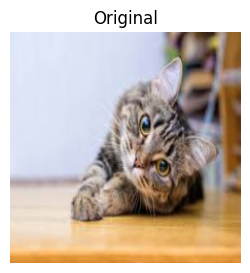

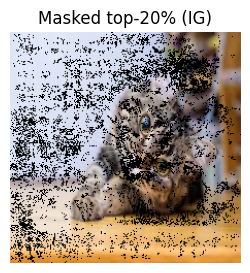

In [ ]:
def mask_top_fraction(pil_img, attr_2d, fraction=0.2, mode="zero"):
    img = np.array(display_transform(pil_img)).astype(np.float32)/255.0
    H, W, _ = img.shape
    k = int(H*W*fraction)
    flat = attr_2d.flatten()
    idx = np.argpartition(flat, -k)[-k:]
    mask = np.ones(H*W, dtype=bool)
    mask[idx] = False
    mask = mask.reshape(H, W)

    img_masked = img.copy()
    if mode == "zero":
        img_masked[~mask] = 0.0
    elif mode == "blur":
        blurred = cv2.GaussianBlur((img*255).astype(np.uint8), (21,21), 0).astype(np.float32)/255.0
        img_masked[~mask] = blurred[~mask]
    img_masked = (img_masked*255).astype(np.uint8)
    return Image.fromarray(img_masked)

def confidence_for_label(pil_img, label_idx):
    probs = predict_proba(prepare_input(pil_img))
    return float(probs[0, label_idx].item())

img = images["cat"]
pred_idx = predict_proba(prepare_input(img)).argmax(dim=1).item()

# используем IG как карту важности
attr = integrated_gradients(img, target=pred_idx, baseline="black", steps=80)

conf_orig = confidence_for_label(img, pred_idx)
img_masked = mask_top_fraction(img, attr, fraction=0.2, mode="zero")
conf_masked = confidence_for_label(img_masked, pred_idx)

print(f"Уверенность до маскирования: {conf_orig:.3f}")
print(f"Уверенность после маскирования (20% топ-пикселей): {conf_masked:.3f}")
show_image(display_transform(img), "Original")
show_image(display_transform(img_masked), "Masked top-20% (IG)")

### Интерпретация для энкодеров

#### Настройка среды

In [ ]:
!pip -q install transformers pymorphy3 lime --upgrade

import torch, numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import LayerIntegratedGradients, FeatureAblation
from lime.lime_text import LimeTextExplainer
from IPython.display import HTML, display

import html
import pymorphy3

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# Возьмем устойчивую русскоязычную модель сентимента
model_name = "blanchefort/rubert-base-cased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_text = AutoModelForSequenceClassification.from_pretrained(model_name, attn_implementation="eager").to(device).eval()
id2label = model_text.config.id2label
label2id = {v:k for k,v in id2label.items()}

# Включим выдачу attention при форварде
model_text.config.output_attentions = True

def encode(text, max_len=128):
    enc = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length',
                    max_length=max_len)
    enc = {k: v.to(device) for k, v in enc.items()}
    # Некоторые токенизаторы не возвращают token_type_ids
    if 'token_type_ids' not in enc:
        enc['token_type_ids'] = None
    return enc

@torch.no_grad()
def predict_proba_text(texts):
    if isinstance(texts, str):
        texts = [texts]
    batch = tokenizer(texts, return_tensors='pt', truncation=True, padding=True)
    batch = {k: v.to(device) for k,v in batch.items()}
    out = model_text(**batch)
    probs = torch.softmax(out.logits, dim=-1).detach().cpu().numpy()
    return probs

def top_label(text):
    probs = predict_proba_text(text)[0]
    idx = int(np.argmax(probs))
    return id2label[idx], float(probs[idx])

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

#### Примеры текстов

In [ ]:
texts = [
    "Очень понравился фильм: отличный сюжет и замечательная игра актеров!",
    "Это худшая покупка в моей жизни. Качество отвратительное, не рекомендую.",
    "Кофе нормальный, но обслуживание могло бы быть лучше."
]

for t in texts:
    lab, p = top_label(t)
    print(f"[{lab} {p:.2f}] {t}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[POSITIVE 0.98] Очень понравился фильм: отличный сюжет и замечательная игра актеров!
[NEGATIVE 0.75] Это худшая покупка в моей жизни. Качество отвратительное, не рекомендую.
[NEUTRAL 0.49] Кофе нормальный, но обслуживание могло бы быть лучше.


#### Integrated Gradients по токенам (через слой эмбеддингов)

In [ ]:
def get_embeddings_layer(m):
    # Унифицируем доступ к эмбеддингам для разных архитектур
    if hasattr(m, 'bert'):
        return m.bert.embeddings
    if hasattr(m, 'roberta'):
        return m.roberta.embeddings
    if hasattr(m, 'distilbert'):
        return m.distilbert.embeddings
    return m.get_input_embeddings()

emb_layer = get_embeddings_layer(model_text)

def forward_func(input_ids, attention_mask, token_type_ids=None):
    out = model_text(input_ids=input_ids,
                     attention_mask=attention_mask,
                     token_type_ids=token_type_ids)
    return out.logits

lig = LayerIntegratedGradients(forward_func, emb_layer)

def ig_token_attributions(text, target_idx=None, n_steps=50, max_len=128):
    enc = encode(text, max_len=max_len)
    input_ids = enc['input_ids']
    attention_mask = enc['attention_mask']
    token_type_ids = enc['token_type_ids']

    with torch.no_grad():
        logits = model_text(input_ids=input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids).logits
        pred_idx = int(torch.argmax(logits, dim=-1).item())
    if target_idx is None:
        target_idx = pred_idx

    baseline_ids = torch.full_like(input_ids, tokenizer.pad_token_id)

    attributions = lig.attribute(
        inputs=input_ids,
        baselines=baseline_ids,
        additional_forward_args=(attention_mask, token_type_ids),
        target=target_idx,
        n_steps=n_steps
    )  # shape: [1, seq_len, hidden]
    # Суммируем по эмбеддинг-каналу -> токен-важность со знаком
    token_attrs = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].detach().cpu().tolist())

    # Нормируем на [-1, 1]
    denom = (np.abs(token_attrs).max() + 1e-6)
    token_scores = token_attrs / denom
    return tokens, token_scores, pred_idx

def colorize_tokens(tokens, scores, special_tokens={'[CLS]', '[SEP]', '[PAD]'}):
    # HTML-подсветка: зеленый = позитивный вклад, красный = негативный
    html_parts = []
    for tok, s in zip(tokens, scores):
        if tok in special_tokens:
            continue
        # Приводим сабтокены WordPiece
        tok_clean = tok.replace("##", "")
        # цвет
        if s >= 0:
            r, g, b = 0, 200, 0
            a = min(0.05 + 0.95*abs(s), 1.0)
        else:
            r, g, b = 200, 0, 0
            a = min(0.05 + 0.95*abs(s), 1.0)
        style = f"background-color: rgba({r},{g},{b},{a}); padding:2px; margin:1px; border-radius:3px;"
        html_parts.append(f"<span style='{style}'>{html.escape(tok_clean)}</span>")
    return " ".join(html_parts)

text = texts[0]
tokens, scores, pred_idx = ig_token_attributions(text, target_idx=None, n_steps=64)
pred_lab = id2label[pred_idx]
display(HTML(f"<b>Текст:</b> {html.escape(text)}"))
display(HTML(f"<b>Класс (target):</b> {pred_lab}"))
display(HTML(colorize_tokens(tokens, scores)))

In [ ]:
text = texts[2]
tokens, scores, pred_idx = ig_token_attributions(text, target_idx=None, n_steps=64)
pred_lab = id2label[pred_idx]
display(HTML(f"<b>Текст:</b> {html.escape(text)}"))
display(HTML(f"<b>Класс (target):</b> {pred_lab}"))
display(HTML(colorize_tokens(tokens, scores)))

В общем случае LayerIntegratedGradients позволяет анализировать, как hidden states на разных слоях трансформера вносят вклад в финальное предсказание. Это дополняет методы типа Logit Lens, показывая не только "что" предсказывается на каждом слое, но и "насколько сильно" каждый компонент представления влияет на этот прогноз.


#### Attention-визуализация (последний слой, среднее по головам)

In [ ]:
def attention_token_importance(text, max_len=128):
    enc = encode(text, max_len)
    outputs = model_text(**{k:v for k,v in enc.items() if v is not None}, output_attentions=True)
    attns = outputs.attentions  # tuple: [num_layers] each [B, heads, L, L]
    last = attns[-1][0]         # [heads, L, L]
    # Важность токена как внимание CLS->токен, усредненное по головам
    cls_attn = last[:, 0, :].mean(dim=0)  # [L]
    cls_attn = cls_attn / (cls_attn.max() + 1e-6)
    tokens = tokenizer.convert_ids_to_tokens(enc['input_ids'][0].detach().cpu().tolist())
    return tokens, cls_attn.detach().cpu().numpy()

text = texts[0]
tokens_attn, attn_scores = attention_token_importance(text)
# Отобразим как позитивную (зеленую) важность
display(HTML("<b>Attention (последний слой, CLS→token):</b>"))
display(HTML(colorize_tokens(tokens_attn, attn_scores)))

In [ ]:
text = """
Anthropic заключила двухлетнее партнерство с Python Software Foundation (PSF). В течение этого периода стартап вложит в сумме 1.5 млн долларов с упором на развитие безопасности и поддержку ключевой инфраструктуры.

В частности, пишут, что планируют создать AI‑инструменты, которые будут автоматически проверять каждый загружаемый на PyPI пакет. Сейчас такого проактивного анализа не существует, только постфактум реакция на жалобы юзеров.
"""
tokens_attn, attn_scores = attention_token_importance(text)
# Отобразим как позитивную (зеленую) важность
display(HTML("<b>Attention (последний слой, CLS→token):</b>"))
display(HTML(colorize_tokens(tokens_attn, attn_scores)))

#### Сравнение IG vs Attention (корреляция Пирсона по токенам)

In [ ]:
import scipy.stats as st

# Маскируем спецтокены
def mask_special(tokens, arr, specials={'[CLS]','[SEP]','[PAD]'}):
    keep = [i for i,t in enumerate(tokens) if t not in specials]
    return np.array([arr[i] for i in keep], dtype=float)

tokens_ig, scores_ig, _ = ig_token_attributions(texts[1], n_steps=64)
tokens_at, scores_at = attention_token_importance(texts[1])

s_ig = mask_special(tokens_ig, scores_ig)
s_at = mask_special(tokens_at, scores_at)

min_len = min(len(s_ig), len(s_at))
r = st.pearsonr(s_ig[:min_len], s_at[:min_len])[0]
print(f"Корреляция IG vs Attention: r = {r:.3f}")

Корреляция IG vs Attention: r = 0.564


#### Feature Ablation для групповой абляции слов

Оценка важности групп слов (например, прилагательных или существительных).

In [ ]:
enc = encode(texts[0], max_len=512)
input_ids = enc['input_ids']
attention_mask = enc['attention_mask']
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
baseline_ids = torch.full_like(input_ids, tokenizer.pad_token_id)

In [ ]:
preds = predict_proba_text(texts[0])
pred_class = torch.tensor(np.argmax(preds))
pred_class

tensor(1)

In [ ]:
def forward_func(input_ids, attention_mask=None):
    outputs = model_text(input_ids=input_ids, attention_mask=attention_mask)
    return torch.softmax(outputs.logits, dim=1)

In [ ]:
morph = pymorphy3.MorphAnalyzer()

# Создание маски признаков по частям речи
def create_pos_feature_mask(tokens, tokenizer):
    feature_mask = torch.zeros(1, len(tokens), dtype=torch.long)
    current_feature_id = 0
    pos_groups = {}

    for i, token in enumerate(tokens):
        if token in ['[CLS]', '[SEP]', '[PAD]']:
            feature_mask[0, i] = -1  # Игнорировать служебные токены
            continue

        # Определение части речи
        parsed = morph.parse(token)[0]
        pos = parsed.tag.POS

        if pos not in pos_groups:
            pos_groups[pos] = current_feature_id
            current_feature_id += 1

        feature_mask[0, i] = pos_groups[pos]

    return feature_mask, pos_groups

feature_mask, pos_groups = create_pos_feature_mask(tokens, tokenizer)

# Feature Ablation с группировкой
fa = FeatureAblation(forward_func)

fa_attr = fa.attribute(
    inputs=input_ids,
    baselines=baseline_ids,
    target=pred_class,
    additional_forward_args=(attention_mask,),
    feature_mask=feature_mask,
    perturbations_per_eval=4  # Обработка нескольких абляций одновременно
)

# Анализ важности частей речи
pos_importance = {}
for pos, feature_id in pos_groups.items():
    mask_indices = (feature_mask[0] == feature_id).nonzero(as_tuple=True)[0]
    pos_importance[pos] = fa_attr[0, mask_indices].mean().item()

print("\nВажность частей речи:")
for pos, importance in sorted(pos_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {pos}: {importance:.4f}")



Важность частей речи:
  VERB: 0.0491
  ADJF: 0.0057
  ADVB: 0.0020
  None: 0.0012
  NOUN: 0.0004
  CONJ: 0.0003


#### LIME для текстовой модели

In [ ]:
def get_interpretability(text):
  probs = predict_proba_text(text)[0]
  pred_idx = int(np.argmax(probs))
  pred_lab = id2label[pred_idx]
  print(f"Pred: {pred_lab} ({probs[pred_idx]:.2f})")

  exp = explainer_text.explain_instance(
      text_instance=text,
      classifier_fn=classifier_fn_text,
      labels=[pred_idx],
      num_features=8
  )

  # Покажем как список слов и весов
  print("LIME важности (топ фичи):")
  for word, weight in exp.as_list(label=pred_idx):
      print(f"{word:20s} {weight:+.3f}")
  return exp

In [ ]:
class_names = [id2label[i] for i in range(len(id2label))]
explainer_text = LimeTextExplainer(class_names=class_names)

def classifier_fn_text(raw_texts):
    probs = predict_proba_text(raw_texts)
    return probs

exp = get_interpretability(texts[0])

# Можно также вывести HTML (колоринг фич)
display(HTML(exp.as_html()))

Pred: POSITIVE (0.98)
LIME важности (топ фичи):
понравился           +0.151
отличный             +0.125
замечательная        +0.122
Очень                +0.024
игра                 -0.017
и                    +0.016
сюжет                -0.012
фильм                -0.011


In [ ]:
exp = get_interpretability(texts[1])
display(HTML(exp.as_html()))


Pred: NEGATIVE (0.75)
LIME важности (топ фичи):
худшая               +0.157
отвратительное       +0.152
не                   +0.039
жизни                +0.020
Это                  +0.019
рекомендую           +0.019
покупка              +0.014
в                    -0.010


In [ ]:
exp = get_interpretability(texts[2])
display(HTML(exp.as_html()))


Pred: NEUTRAL (0.49)
LIME важности (топ фичи):
нормальный           -0.095
лучше                -0.071
могло                +0.063
бы                   +0.060
обслуживание         -0.049
но                   +0.047
быть                 +0.044
Кофе                 -0.010
